In [63]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression as LR
from tools import *
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from skopt.plots import plot_gaussian_process
from skopt import gp_minimize


In [78]:
with open('sample_list.pkl', 'rb') as f:
    D = pickle.load(f)
with open('sample_list_100.pkl', 'rb') as f:
    D |= pickle.load(f)
with open('sample_list_200.pkl', 'rb') as f:
    D |= pickle.load(f)
with open('sample_list_300.pkl', 'rb') as f:
    D |= pickle.load(f)
with open('sample_list_400.pkl', 'rb') as f:
    D |= pickle.load(f)

In [97]:
D[0]

{'S': {'Chord': 9.465232623567857,
  'Span': 9.191411087456556,
  'SweepDistance': 6.313146341736696,
  'TipChord': 6.181568139405},
 'B': {'Chord': 4.2532186078635155,
  'Span': 3.3627664522675493,
  'SweepDistance': 2.0042503349788507,
  'TipChord': 3.767645277160544}}

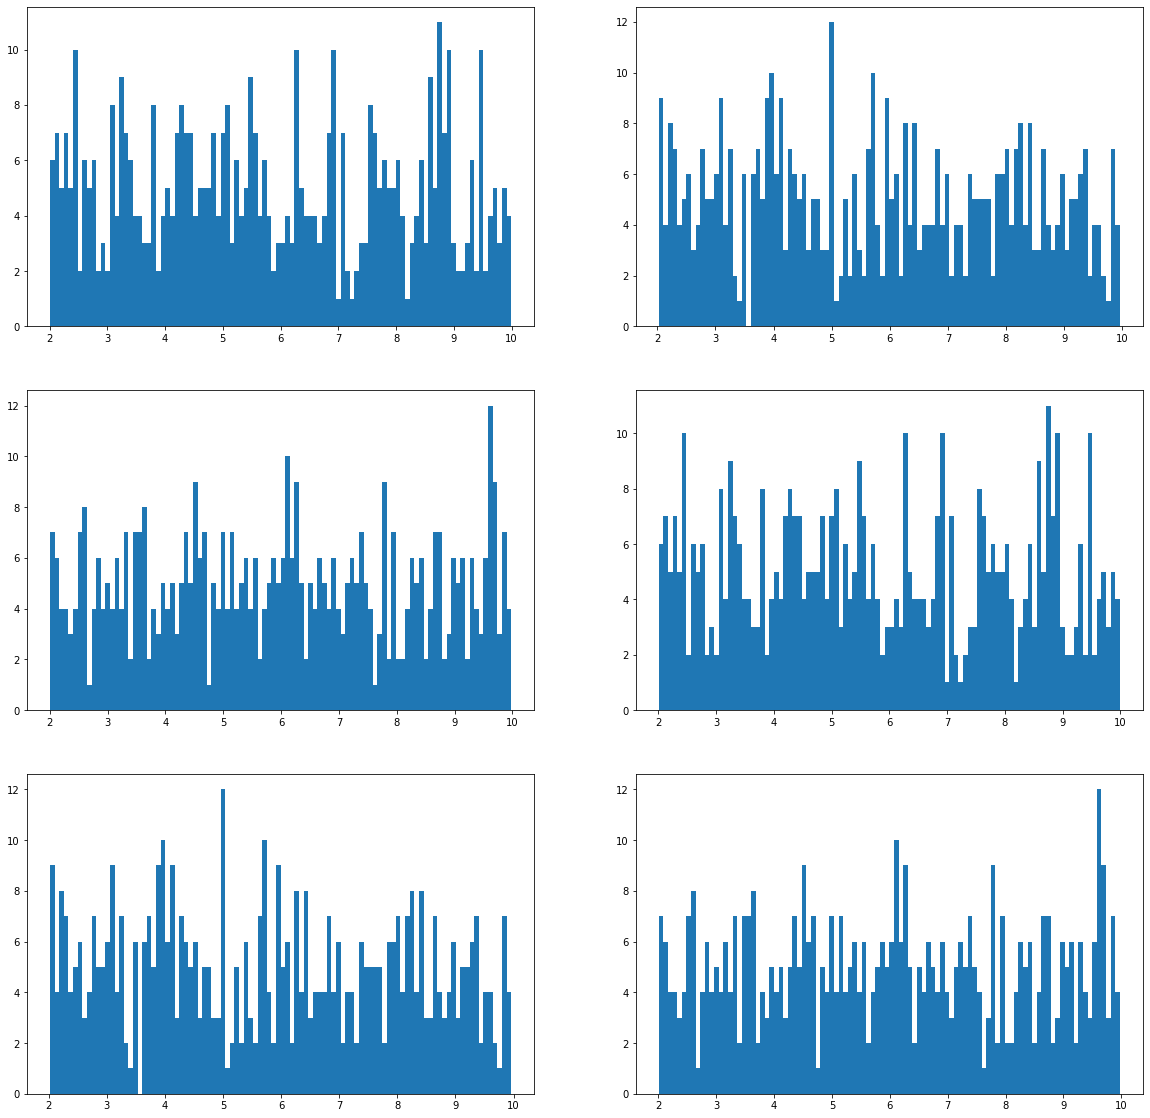

In [108]:
f = plt.figure(figsize=(20,20))
ax1 = f.add_subplot(321)
ax2 = f.add_subplot(322)
ax3 = f.add_subplot(323)
ax4 = f.add_subplot(324)
ax5 = f.add_subplot(325)
ax6 = f.add_subplot(326)

ax1.hist([D[x]['S']['Chord'] for x in D], bins=100);
ax2.hist([D[x]['S']['Span'] for x in D], bins=100);
ax3.hist([D[x]['S']['SweepDistance'] for x in D], bins=100);
ax4.hist([D[x]['S']['Chord'] for x in D], bins=100);
ax5.hist([D[x]['S']['Span'] for x in D], bins=100);
ax6.hist([D[x]['S']['SweepDistance'] for x in D], bins=100);


In [55]:
num = 1
def print_stuff(num):
    df = pd.read_csv("./samples/" + str(num) + ".csv")
    cols = df.columns
    print(np.max(df.loc[:,"Altitude (ft)"]))
    print(np.min(df.loc[:,'Stability Margin (cal)']) * 10000)
# def score_function(x):
#     x[]

In [68]:
from skopt import gp_minimize

res = gp_minimize(f,                  # the function to minimize
                  [0, 15],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=15,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234)   # the random seed

ValueError: Dimension has to be a list or tuple.

In [69]:
from skopt import gp_minimize
noise_level = 0.1

def f(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2))\
           + np.random.randn() * noise_level
res = gp_minimize(f,                  # the function to minimize
                  [(-2.0, 2.0)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=15,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234)   # the random seed

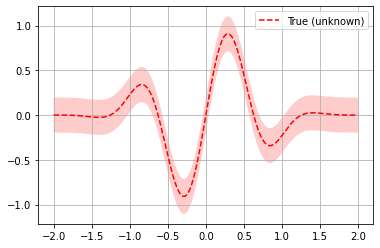

In [71]:
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx],
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()
plt.show()

In [73]:
res.x[0], res.fun

(-0.3217742251575595, -0.9865463668702567)

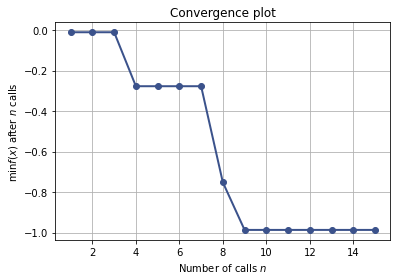

In [74]:
from skopt.plots import plot_convergence
plot_convergence(res);

In [75]:
plt.rcParams["figure.figsize"] = (8, 14)


def f_wo_noise(x):
    return f(x, noise_level=0)

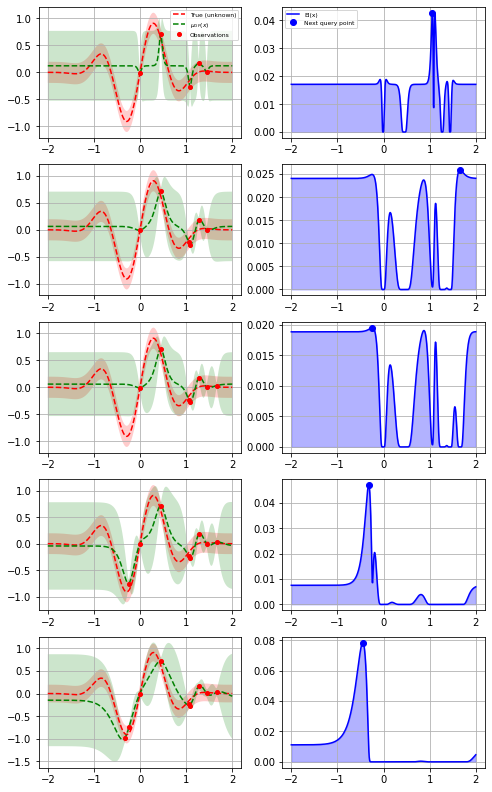

In [76]:
for n_iter in range(5):
    # Plot true function.
    plt.subplot(5, 2, 2*n_iter+1)

    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False

    ax = plot_gaussian_process(res, n_calls=n_iter,
                               objective=f_wo_noise,
                               noise_level=noise_level,
                               show_legend=show_legend, show_title=False,
                               show_next_point=False, show_acq_func=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    # Plot EI(x)
    plt.subplot(5, 2, 2*n_iter+2)
    ax = plot_gaussian_process(res, n_calls=n_iter,
                               show_legend=show_legend, show_title=False,
                               show_mu=False, show_acq_func=True,
                               show_observations=False,
                               show_next_point=True)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.show()

In [3]:
from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
from tools import *

# 
save_folder = 'bayesian_data'
run = 1

save_folder += "/" + str(run) + "/"
if not os.path.exists(save_folder):
    os.mkdir(save_folder)

parameters_folder = save_folder + "parameters/"
if not os.path.exists(parameters_folder):
    os.mkdir(parameters_folder)
results_folder = save_folder + "results/"
if not os.path.exists(results_folder):
    os.mkdir(results_folder)

# np.savetxt(save_folder + "hello.txt",np.array([1,2,3]), delimiter=",")


# objective function
# we generate the data by asking the user to input our values into the simulator and then we get the output
# in a true rocket simulation, there will be uncertainty which varies based on parameters. This uncertainty
# is caused by factors like wind, which may have different effects on different rockets. Hence 
# rockets can have differing uncertainties, so these uncertainties should be taken into account.
# Unfortunately, our simulator does not have this uncertainty, so we will have to add it in manually
# x represents an 8-d vector of input parameters: S-chord, S-span, S-sweep distance; B-chord, B-span, B-sweep distance
sample_num = 0
def objective_function(df):
    # df = pd.read_csv(results_folder + str(sample_num) + ".csv")
    return -(np.max(df.loc[:,"Altitude (ft)"]) + 10000 * np.min(df.loc[:,'Stability Margin (cal)']) )

def objective(input_parameters, noise=0.0):
    # for i in range(prefix, prefix+num):        
    sustainer = {'Chord': input_parameters[0],
                    'Span': input_parameters[1],
                    'SweepDistance': input_parameters[2],
                    'TipChord': input_parameters[3]}
    booster = {'Chord': input_parameters[4],
                    'Span': input_parameters[5],
                    'SweepDistance': input_parameters[6],
                    'TipChord': input_parameters[7]}
    # samples[i] = {'S': sustainer, 'B': booster}
    generateNewDesign(booster, sustainer, parameters_folder + f"sample_{sample_num}.CDX1")
    input("Please run the simulation and save results in " + results_folder + f"{sample_num}.csv . Press enter when done.")
    
    # f = open(f'sample_list_{prefix}.pkl', 'wb')
    # pickle.dump(samples, f)
    # f.close()
    df = pd.read_csv(results_folder + f"{sample_num}.csv")
    sample_num += 1
    score = objective_function(df) + normal(loc=0, scale=noise)
    print("Rocket number " + str(sample_num) + " has a score of " + str(score) + ".")
    return score
    
    # print(np.max(df.loc[:,"Altitude (ft)"]))
    # print(np.min(df.loc[:,'Stability Margin (cal)']) * 10000)
    
    # noise = normal(loc=0, scale=noise)
    # print(f"".format())
    # altitude = float(input("Enter the altitude"))
    # stability = float(input("Enter the "))
    # return 
    

# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    # with catch_warnings():
    # # ignore generated warnings
    # simplefilter("ignore")
    return model.predict(X, return_std=True)
 
# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    # mu = mu[:, 0]
    mu = mu.reshape(len(mu), 1)
    # calculate the probability of improvement
    probs = norm.cdf((mu - best) / (std+1E-9))
    return probs
 
# optimize the acquisition function
def opt_acquisition(X, y, model):
    # random search, generate random samples
    Xsamples = random(100)
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    # calculate the acquisition function for each sample
    scores = acquisition(X, Xsamples, model)
    # locate the index of the largest scores
    ix = argmax(scores)
    return Xsamples[ix, 0]
 
# plot real observations vs surrogate function
def plot(X, y, model):
    # scatter plot of inputs and real objective function
    pyplot.scatter(X, y)
    # line plot of surrogate function across domain
    Xsamples = asarray(arange(0, 1, 0.001))
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    ysamples, _ = surrogate(model, Xsamples)
    pyplot.plot(Xsamples, ysamples)
    # show the plot
    pyplot.show()

# sample the domain sparsely with noise
X = random(100)
y = asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model)
# perform the optimization process
for i in range(100):
# select the next point to sample
    x = opt_acquisition(X, y, model)
    # sample the point
    actual = objective(x)
    # summarize the finding
    est, _ = surrogate(model, [[x]])
    print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
    # add the data to the dataset
    X = vstack((X, [[x]]))
    y = vstack((y, [[actual]]))
    # update the model
    model.fit(X, y)

# plot all samples and the final surrogate function
plot(X, y, model)
# best result
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))

TypeError: array() takes from 1 to 2 positional arguments but 3 were given